# Amazon Fine Food Reviews Analysis- sentimental analysis using Naive Bayes

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10 

Attribute Information:

1) Id 

2) ProductId - unique identifier for the product 

3) UserId - unqiue identifier for the user  

4) ProfileName 

5) HelpfulnessNumerator - number of users who found the review helpful 

6) HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

7) Score - rating between 1 and 5 

8) Time - timestamp for the review 

9) Summary - brief summary of the review 10) Text - text of the review Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

# [Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Loading the data

The dataset is available in two forms 1).csv file 2)SQLite Database In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

we will make postive label as 1 and negative score as 0 becoz we are taking log loss as metric.

# Exploratory Data Analysis


In [19]:
#importing required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sqlite3

import re
import nltk
import matplotlib.pyplot as plt
from  nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import seaborn as sn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
#loading the data using sqlite
con = sqlite3.connect(r'C:\\Users\\Dell\\Downloads\\amazon-fine-food-reviews\\database.sqlite')
data = pd.read_sql_query('select * from reviews where Score !=3',con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [21]:
data.shape

(525814, 10)

In [22]:
def change_labels(x):
    if int(x) > 3:
        return 1
    return 0
temp_score = data['Score']
temp_score = temp_score.map(change_labels)
data['Score'] =  temp_score
data['Score'].head()

0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64

In [23]:
#Removing Duplicates
print('Number of data points before removing duplicates',data.shape[0])
sorted_data=data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
clean_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Number of data points after removing duplicates',clean_data.shape[0])

Number of data points before removing duplicates 525814
Number of data points after removing duplicates 364173


In [24]:
clean_data=clean_data[clean_data['HelpfulnessNumerator']<=clean_data['HelpfulnessDenominator']]
print('Now the Number of data points are',clean_data.shape[0])

Now the Number of data points are 364171


# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

 1) Begin by removing the html tags
 
 2) Remove any punctuations or limited set of special characters like , or . or # etc.
 
 3) Check if the word is made up of english letters and is not alpha-numeric
 
 4) Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
 
 5) Convert the word to lowercase
 
 6) Remove Stopwords
 
 7) Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [25]:
#lets define some functions to  clean the reviews

#to remove HTML Tags
def clean_html(x):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', x)
    return cleantext
#  to remove unwanted charecteres like '!',',' etc.

def cleansen(x):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',x)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

#stop words

stop_words = set(stopwords.words('english'))
#intialising stremming
stemmer = nltk.stem.SnowballStemmer('english')
import datetime

In [26]:
import datetime

str1=' '
final_string=[]

s=''
start_time = datetime.datetime.now()
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=clean_html(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleansen(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop_words):
                    s=(stemmer.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
        
    final_string.append(str1)
clean_data['CleanedText']=final_string
print('Total time taken to clean the reviews',datetime.datetime.now()-start_time)

Total time taken to clean the reviews 0:07:43.925189


In [27]:
clean_data['CleanedText'].head()

138706    b'witti littl book make son laugh loud recit c...
138688    b'grew read sendak book watch realli rosi movi...
138689    b'fun way children learn month year learn poem...
138690    b'great littl book read nice rhythm well good ...
138691    b'book poetri month year goe month cute littl ...
Name: CleanedText, dtype: object

In [32]:
clean_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [28]:
final_data = clean_data.head(100000)
final_data.shape

(100000, 11)

In [34]:
final_data.to_pickle("C:/Users/Dell/Downloads/amazon-fine-food-reviews/final_data.pkl")

In [35]:
data = pd.read_pickle("C:/Users/Dell/Downloads/amazon-fine-food-reviews/final_data.pkl")

In [36]:
data.shape

(100000, 11)

# Split the dataset randomly into three parts train, cross validation and test with 64%,16%, 20% of data respectively

In [37]:
#noe lets split the data 
from sklearn.model_selection import train_test_split
x,x_test,y,y_test = train_test_split(data['CleanedText'],data['Score'],train_size=0.8,shuffle=False)
x_train,x_cv,y_train,y_cv = train_test_split(x,y,train_size=0.8,shuffle=False)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.

In [38]:
#Lets Vecotirize
#bagof words
bag_words = CountVectorizer()
x_train_bag= bag_words.fit_transform(x_train)
x_test_bag= bag_words.transform(x_test)
x_cv_bag= bag_words.transform(x_cv)

print('After vectorizing shape of x Train',x_train_bag.shape)
print('After vectorizing shape of x Test',x_test_bag.shape)
print('After vectorizing shape of x CV',x_cv_bag.shape)

After vectorizing shape of x Train (64000, 30957)
After vectorizing shape of x Test (20000, 30957)
After vectorizing shape of x CV (16000, 30957)


# Multinomial Naive bayees

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts)

For values of alpa =  0.0001 The f1 score 0.9408101918121957
For values of alpa =  0.001 The f1 score 0.9424463011439022
For values of alpa =  0.01 The f1 score 0.9447402503957404
For values of alpa =  0.1 The f1 score 0.9471745802491425
For values of alpa =  1 The f1 score 0.9519179208522504
For values of alpa =  10 The f1 score 0.9331940137521909
For values of alpa =  100 The f1 score 0.9282604327148504
For values of alpa =  1000 The f1 score 0.9282963260658428


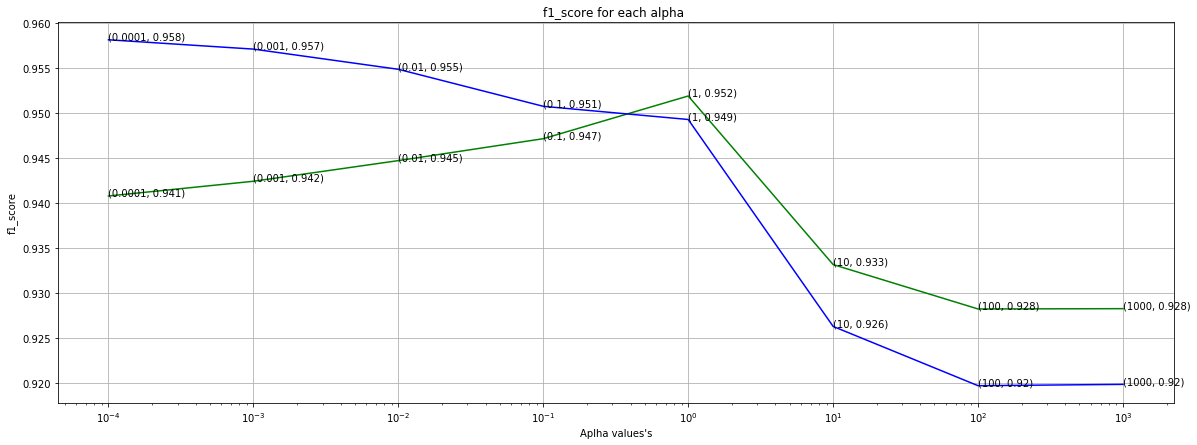

For values of alpa =  0.0625 The f1 score 0.946403435954813
For values of alpa =  0.125 The f1 score 0.9476687493228357
For values of alpa =  0.25 The f1 score 0.9484662576687117
For values of alpa =  0.5 The f1 score 0.9496868926797668
For values of alpa =  1 The f1 score 0.9519179208522504
For values of alpa =  2 The f1 score 0.9527600662274984
For values of alpa =  4 The f1 score 0.9471215204718706
For values of alpa =  8 The f1 score 0.9364654909792506


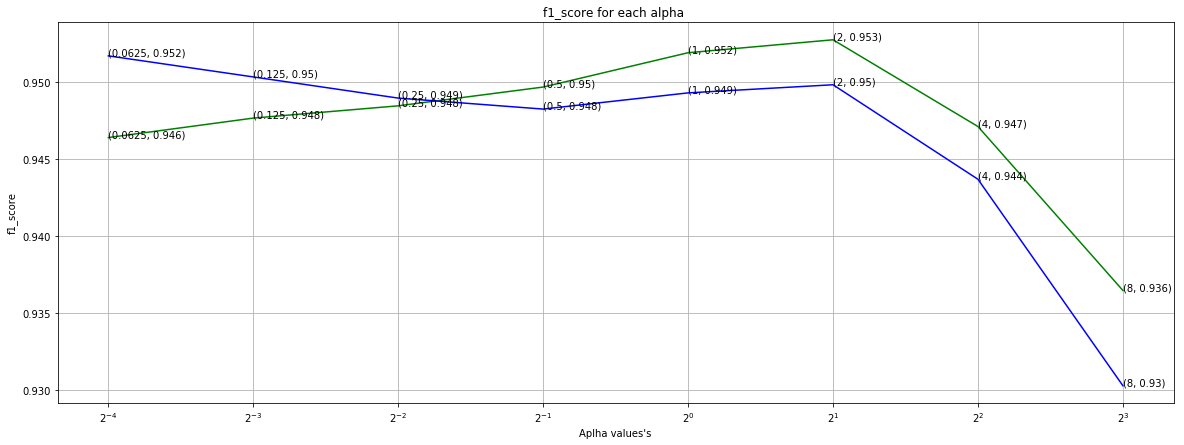

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix,f1_score
import seaborn as sns
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker

#lets do hyper parameter tuning now

range1 = [10 ** x for x in range(-4,4)] 
range2 = [ 2 ** x for x in range(-4,4)]
#alpha = range1 + range2
alpha = [range1,range2]
for r in alpha: 
    
    cv_f1_score_array=[]
    train_f1_score_array=[]
    for i  in r:
        clf_bag = MultinomialNB(alpha = i )
        clf_bag.fit(x_train_bag,y_train)
        predict_y = clf_bag.predict(x_cv_bag)
        predict_y_train = clf_bag.predict(x_train_bag)
        cv_f1_score_array.append(f1_score(y_cv, predict_y))
        train_f1_score_array.append(f1_score(y_train, predict_y_train))
        print('For values of alpa = ', i, "The f1 score",f1_score(y_cv, predict_y))
    if(r == range1):
            fig, ax = plt.subplots(figsize=(20,7))
            
            plt.xscale('log')
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()
    else:
            fig, ax = plt.subplots(figsize=(20,7))
            ax.set_xscale('log', basex=2)
            
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()

By looking above plots we can say alpha value as 0.25

f1score on train data is : 0.9489689956979677
Accuracy on train data is : 91.4
f1score on test data is : 0.9341633318511932
Accuracy on test data is  88.895
-------------------- Confusion matrix --------------------


<Figure size 1440x504 with 0 Axes>

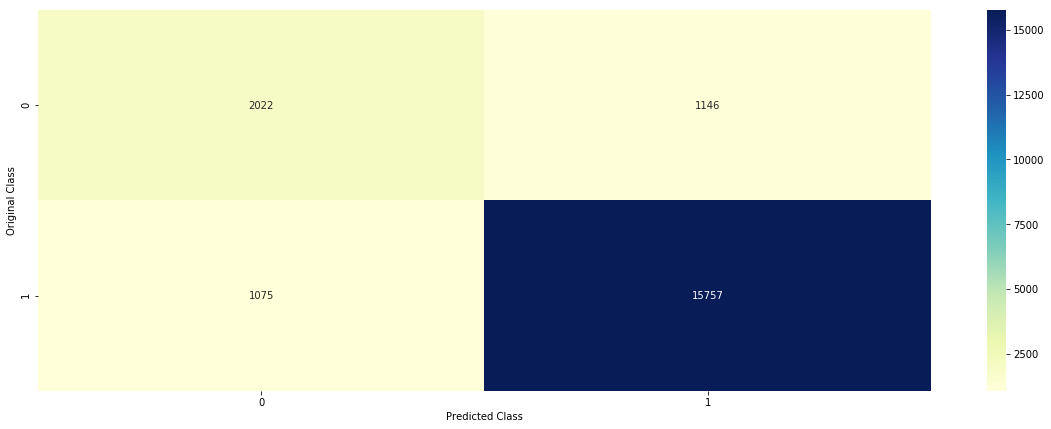

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      3168
           1       0.93      0.94      0.93     16832

   micro avg       0.89      0.89      0.89     20000
   macro avg       0.79      0.79      0.79     20000
weighted avg       0.89      0.89      0.89     20000



In [40]:
best_alpha_bow = 0.25
clf_bag_best = MultinomialNB(alpha = best_alpha_bow )
clf_bag_best.fit(x_train_bag, y_train)
predict_y = clf_bag_best.predict(x_train_bag)
print('f1score on train data is :',f1_score(y_train,predict_y))
print('Accuracy on train data is :',accuracy_score(y_train,predict_y)*100)

predict_y = clf_bag_best.predict(x_test_bag)

acc_bag = accuracy_score(y_test,predict_y)
print('f1score on test data is :',f1_score(y_test,predict_y))
print('Accuracy on test data is ',acc_bag*100)

C = confusion_matrix(y_test, predict_y)

print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(20,7))
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
print(classification_report(y_test, predict_y))

In [41]:
#printing the important features
log_prob = clf_bag_best.feature_log_prob_
bag_features = bag_words.get_feature_names()
feature_prob = pd.DataFrame(log_prob, columns = bag_features)
feature_prob_bag = feature_prob.T
feature_prob_bag.shape

(30957, 2)

In [42]:
print("Top 20 negative features:-\n",feature_prob_bag[0].sort_values(ascending = False)[0:20])
print("\n\n Top 20 positive features:-\n",feature_prob_bag[1].sort_values(ascending = False)[0:20])

Top 20 negative features:-
 tast      -4.384116
like      -4.393441
product   -4.451957
one       -4.750718
would     -4.944157
tea       -4.969019
tri       -4.974960
flavor    -5.051556
use       -5.068587
food      -5.075151
good      -5.108638
get       -5.148587
buy       -5.169628
order     -5.196220
dont      -5.274474
dog       -5.287623
box       -5.307159
bag       -5.335593
even      -5.392744
eat       -5.409855
Name: 0, dtype: float64


 Top 20 positive features:-
 tea       -4.446648
like      -4.543737
tast      -4.629236
use       -4.670388
good      -4.708215
love      -4.710128
great     -4.743731
one       -4.813980
flavor    -4.832914
product   -4.916880
tri       -4.966461
make      -4.993692
get       -5.092413
food      -5.218467
time      -5.298046
find      -5.412826
buy       -5.415702
eat       -5.430659
best      -5.443335
dog       -5.454444
Name: 1, dtype: float64


# Observations

1)From above plot(F1_score vs optimal alpha) for alpha =0.25 we are getting good f1 train and test scores.

2)In confusion matrix, we can see diagonal elements values are high which means our model performing good.

3)with unseen data,we are getting accuracy of 88.85%

# TF-IDF

In [43]:
tfidf_words = TfidfVectorizer()
x_train_tfidf= tfidf_words.fit_transform(x_train)
x_test_tfidf= tfidf_words.transform(x_test)
x_cv_tfidf = tfidf_words.transform(x_cv)

print('After vectorizing shape of x Train',x_train_tfidf.shape)
print('After vectorizing shape of x Test',x_test_tfidf.shape)
print('After vectorizing shape of x CV',x_cv_tfidf.shape)

After vectorizing shape of x Train (64000, 30957)
After vectorizing shape of x Test (20000, 30957)
After vectorizing shape of x CV (16000, 30957)


For values of alpa =  0.0001 The f1 score 0.9367279197892072
For values of alpa =  0.001 The f1 score 0.9372926003215765
For values of alpa =  0.01 The f1 score 0.9397005537704246
For values of alpa =  0.1 The f1 score 0.9402181322426721
For values of alpa =  1 The f1 score 0.9300359048354082
For values of alpa =  10 The f1 score 0.9282963260658428
For values of alpa =  100 The f1 score 0.9282963260658428
For values of alpa =  1000 The f1 score 0.9282963260658428


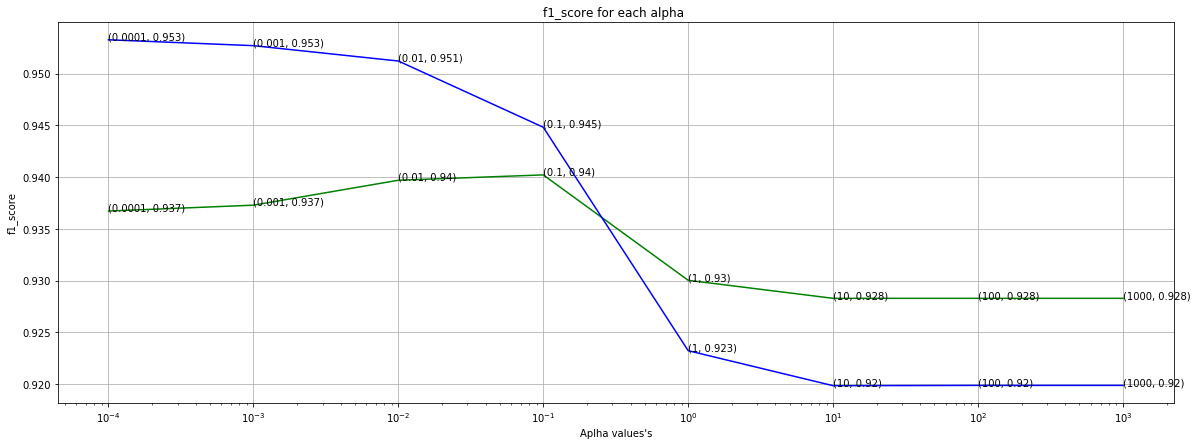

For values of alpa =  0.015625 The f1 score 0.940404592673592
For values of alpa =  0.03125 The f1 score 0.9405375866662113
For values of alpa =  0.0625 The f1 score 0.9407227928881001
For values of alpa =  0.125 The f1 score 0.9400824334911606
For values of alpa =  0.25 The f1 score 0.9374830485489558
For values of alpa =  0.5 The f1 score 0.9339492228328669
For values of alpa =  1 The f1 score 0.9300359048354082
For values of alpa =  2 The f1 score 0.9285092127303183
For values of alpa =  4 The f1 score 0.9282963260658428
For values of alpa =  8 The f1 score 0.9282963260658428
For values of alpa =  16 The f1 score 0.9282963260658428
For values of alpa =  32 The f1 score 0.9282963260658428


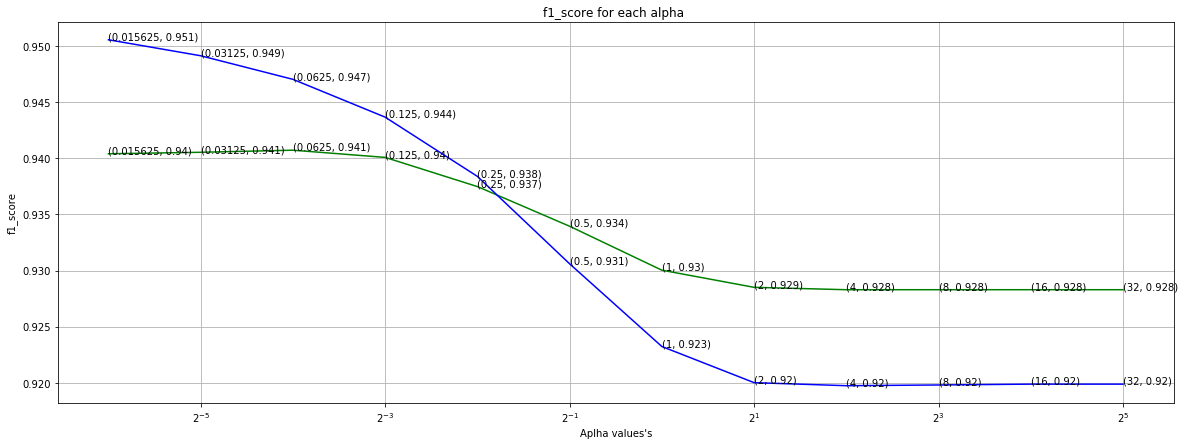

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss,accuracy_score,confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
#lets do hyper parameter tuning now
#lets do hyper parameter tuning now

range1 = [10 ** x for x in range(-4,4)] 
range2 = [ 2 ** x for x in range(-6,6)]
#alpha = range1 + range2
alpha = [range1,range2]
for r in alpha: 
    
    cv_f1_score_array=[]
    train_f1_score_array=[]
    for i  in r:
        clf_bag = MultinomialNB(alpha = i )
        clf_bag.fit(x_train_tfidf,y_train)
        predict_y = clf_bag.predict(x_cv_tfidf)
        predict_y_train = clf_bag.predict(x_train_tfidf)
        cv_f1_score_array.append(f1_score(y_cv, predict_y))
        train_f1_score_array.append(f1_score(y_train, predict_y_train))
        print('For values of alpa = ', i, "The f1 score",f1_score(y_cv, predict_y))
    if(r == range1):
            fig, ax = plt.subplots(figsize=(20,7))
            
            plt.xscale('log')
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()
    else:
            fig, ax = plt.subplots(figsize=(20,7))
            ax.set_xscale('log', basex=2)
            
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()

taking best alpha value as 0.25

f1score on train data is : 0.9383901811240574
Accuracy on train data is : 88.8546875
f1score on test data is : 0.9420493282534589
Accuracy on test data is  89.885
-------------------- Confusion matrix --------------------


<Figure size 1440x504 with 0 Axes>

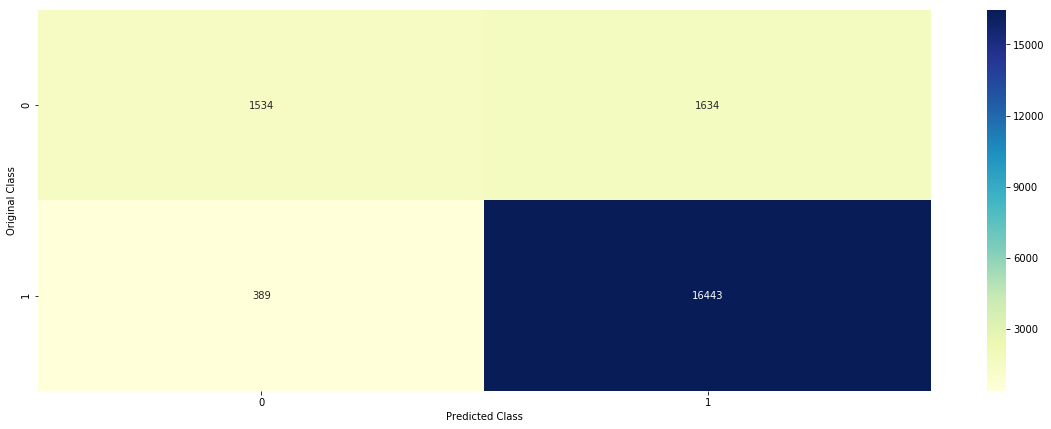

              precision    recall  f1-score   support

           0       0.80      0.48      0.60      3168
           1       0.91      0.98      0.94     16832

   micro avg       0.90      0.90      0.90     20000
   macro avg       0.85      0.73      0.77     20000
weighted avg       0.89      0.90      0.89     20000



In [45]:
best_alpha_tfidf = 0.25
clf_tfidf_best = MultinomialNB(alpha = best_alpha_tfidf )
clf_tfidf_best .fit(x_train_tfidf, y_train)
predict_y = clf_tfidf_best.predict(x_train_tfidf)
print('f1score on train data is :',f1_score(y_train,predict_y))
print('Accuracy on train data is :',accuracy_score(y_train,predict_y)*100)

predict_y = clf_tfidf_best.predict(x_test_bag)

acc_tfidf = accuracy_score(y_test,predict_y)
print('f1score on test data is :',f1_score(y_test,predict_y))
print('Accuracy on test data is ',acc_tfidf*100)


C = confusion_matrix(y_test, predict_y)

print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(20,7))
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
print(classification_report(y_test, predict_y))

In [46]:
#printing the important features
log_prob = clf_tfidf_best.feature_log_prob_
tfidf_features = tfidf_words.get_feature_names()
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_bag = feature_prob.T
feature_prob_bag.shape

(30957, 2)

In [47]:
print("Top 20 negative features:-\n",feature_prob_bag[0].sort_values(ascending = False)[0:20])
print("\n\n Top 20 positive features:-\n",feature_prob_bag[1].sort_values(ascending = False)[0:20])

Top 20 negative features:-
 tast         -5.075296
product      -5.137854
like         -5.177555
would        -5.492188
one          -5.514936
tea          -5.529719
order        -5.625002
buy          -5.651377
tri          -5.677593
flavor       -5.688325
box          -5.711517
dog          -5.767227
dont         -5.767873
disappoint   -5.807237
good         -5.823675
get          -5.828331
food         -5.836529
bag          -5.836772
use          -5.904593
even         -5.925445
Name: 0, dtype: float64


 Top 20 positive features:-
 tea       -4.869499
great     -5.096738
love      -5.110994
good      -5.194902
tast      -5.228223
like      -5.256520
use       -5.309518
product   -5.339280
flavor    -5.352095
one       -5.467646
make      -5.537003
tri       -5.541485
get       -5.641047
best      -5.657591
dog       -5.686775
find      -5.703858
buy       -5.713891
food      -5.719795
time      -5.735033
order     -5.739257
Name: 1, dtype: float64


# Observations

1)From above plot(f1score vs optimal alpha) for alpha=0.25 , we are getting good f1 score

2)In confusion matrix, we can see diagonal elements values are high which means our model performing good 

3)with unseen data,we are getting accuracy of 89.85%

# Lets test model by adding one more fetures i.e., summary column to text

In [48]:
data['adtionaltext'] = data['Text'].str.cat(data['Summary'])
data['adtionaltext'] .head()


138706    this witty little book makes my son laugh at l...
138688    I grew up reading these Sendak books, and watc...
138689    This is a fun way for children to learn their ...
138690    This is a great little book to read aloud- it ...
138691    This is a book of poetry about the months of t...
Name: adtionaltext, dtype: object

In [49]:
import datetime

str1=' '
final_string=[]

s=''
start_time = datetime.datetime.now()
for sent in data['adtionaltext'].values:
    filtered_sentence=[]
    sent=clean_html(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleansen(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop_words):
                    s=(stemmer.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
        
    final_string.append(str1)
data['adtionaltext']=final_string
print('Total time taken to clean the reviews',datetime.datetime.now()-start_time)


Total time taken to clean the reviews 0:02:25.155363


In [50]:
data['adtionaltext'].head()

138706    b'witti littl book make son laugh loud recit c...
138688    b'grew read sendak book watch realli rosi movi...
138689    b'fun way children learn month year learn poem...
138690    b'great littl book read nice rhythm well good ...
138691    b'book poetri month year goe month cute littl ...
Name: adtionaltext, dtype: object

In [51]:
#noe lets split the data 
from sklearn.model_selection import train_test_split
x,x_test_add,y,y_test_add = train_test_split(data['adtionaltext'],data['Score'],train_size=0.8)
x_train_add,x_cv_add,y_train_add,y_cv_add = train_test_split(x,y,train_size=0.8)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [52]:
#bagof words
bag_words = CountVectorizer()
x_train_bag_add= bag_words.fit_transform(x_train_add)
x_test_bag_add= bag_words.transform(x_test_add)
x_cv_bag_add= bag_words.transform(x_cv_add)

print('After vectorizing shape of x Train',x_train_bag_add.shape)
print('After vectorizing shape of x Test',x_test_bag_add.shape)
print('After vectorizing shape of x CV',x_cv_bag_add.shape)

After vectorizing shape of x Train (64000, 43594)
After vectorizing shape of x Test (20000, 43594)
After vectorizing shape of x CV (16000, 43594)


For values of alpa =  0.0001 The f1 score 0.941712605659684
For values of alpa =  0.001 The f1 score 0.9422814836642234
For values of alpa =  0.01 The f1 score 0.9435692626285037
For values of alpa =  0.1 The f1 score 0.9443311204242851
For values of alpa =  1 The f1 score 0.9492426449169822
For values of alpa =  10 The f1 score 0.923019508057676
For values of alpa =  100 The f1 score 0.91957593355392
For values of alpa =  1000 The f1 score 0.9196124109524292


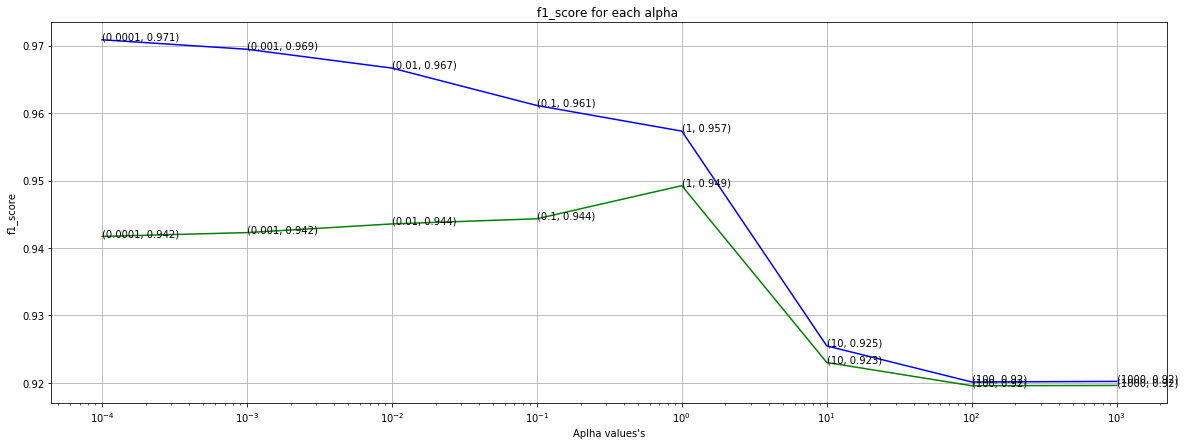

For values of alpa =  0.0625 The f1 score 0.9445906378562692
For values of alpa =  0.125 The f1 score 0.9442301987540789
For values of alpa =  0.25 The f1 score 0.945010183299389
For values of alpa =  0.5 The f1 score 0.9462825141846584
For values of alpa =  1 The f1 score 0.9492426449169822
For values of alpa =  2 The f1 score 0.9498072254747965
For values of alpa =  4 The f1 score 0.9393802385837999
For values of alpa =  8 The f1 score 0.9263157894736843


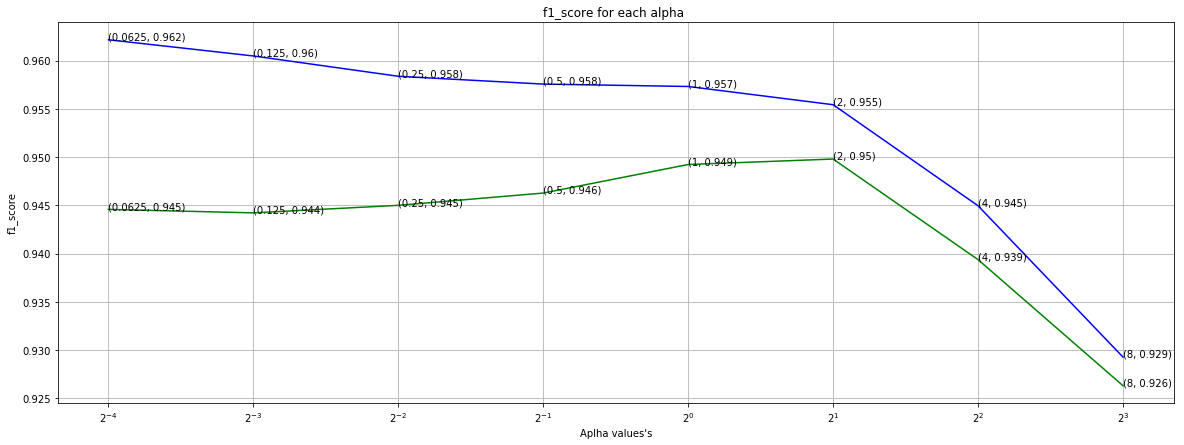

In [53]:
#lets do hyper parameter tuning now

range1 = [10 ** x for x in range(-4,4)] 
range2 = [ 2 ** x for x in range(-4,4)]
#alpha = range1 + range2
alpha = [range1,range2]
for r in alpha: 
    
    cv_f1_score_array=[]
    train_f1_score_array=[]
    for i  in r:
        clf_bag = MultinomialNB(alpha = i )
        clf_bag.fit(x_train_bag_add,y_train_add)
        predict_y = clf_bag.predict(x_cv_bag_add)
        predict_y_train = clf_bag.predict(x_train_bag_add)
        cv_f1_score_array.append(f1_score(y_cv_add, predict_y))
        train_f1_score_array.append(f1_score(y_train_add, predict_y_train))
        print('For values of alpa = ', i, "The f1 score",f1_score(y_cv_add, predict_y))
    if(r == range1):
            fig, ax = plt.subplots(figsize=(20,7))
            
            plt.xscale('log')
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()
    else:
            fig, ax = plt.subplots(figsize=(20,7))
            ax.set_xscale('log', basex=2)
            
            plt.plot(r, cv_f1_score_array,c='g')
            plt.plot(r, train_f1_score_array,c='b')
            for i, txt in enumerate(np.round(cv_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],cv_f1_score_array[i]))
            for i, txt in enumerate(np.round(train_f1_score_array,3)):
                ax.annotate((r[i],np.round(txt,3)), (r[i],train_f1_score_array[i]))
            plt.grid()
            plt.title("f1_score for each alpha ")
            plt.xlabel("Aplha values's")
            plt.ylabel("f1_score")
            plt.show()

f1score on train data is : 0.9254783398867101
Accuracy on train data is : 86.2890625
f1score on test data is : 0.9239747034714871
Accuracy on test data is  85.995
-------------------- Confusion matrix --------------------


<Figure size 1440x504 with 0 Axes>

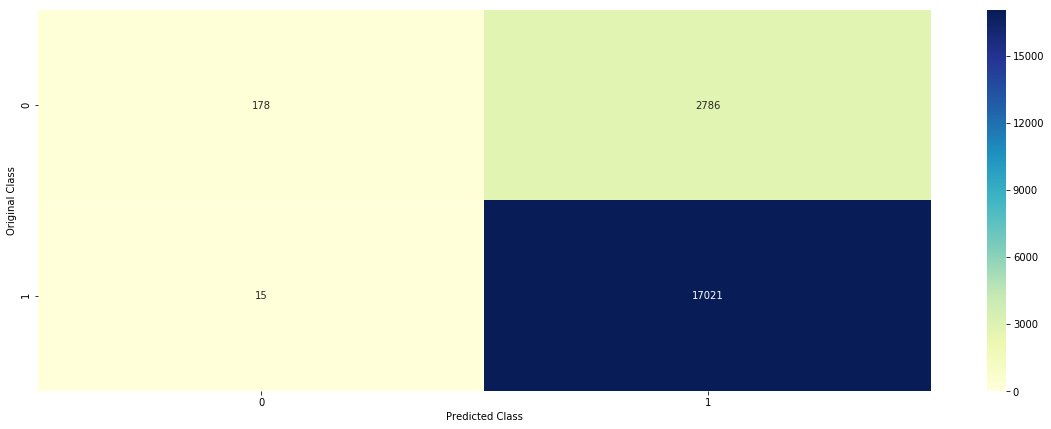

              precision    recall  f1-score   support

           0       0.17      0.01      0.02      3168
           1       0.84      0.99      0.91     16832

   micro avg       0.84      0.84      0.84     20000
   macro avg       0.51      0.50      0.46     20000
weighted avg       0.74      0.84      0.77     20000



In [54]:
best_alpha_bow = 10
clf_bag_best = clf_bag_best = MultinomialNB(alpha = best_alpha_bow )
clf_bag_best.fit(x_train_bag_add, y_train_add)
predict_y = clf_bag_best.predict(x_train_bag_add)

print('f1score on train data is :',f1_score(y_train_add,predict_y))
print('Accuracy on train data is :',accuracy_score(y_train_add,predict_y)*100)

predict_y = clf_bag_best.predict(x_test_bag_add)

acc_tfidf = accuracy_score(y_test_add,predict_y)
print('f1score on test data is :',f1_score(y_test_add,predict_y))
print('Accuracy on test data is ',acc_tfidf*100)


C = confusion_matrix(y_test_add, predict_y)

print("-"*20, "Confusion matrix", "-"*20)
plt.figure(figsize=(20,7))
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()
print(classification_report(y_test, predict_y))

# Conclusion:

Looking above table both of the models are performing well on unseen data